### Kaggle 문제
- https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

### Import Packages

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from copy import deepcopy
import time

### Setup seed

In [ ]:
import random
import os

# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (device)

seed = 42 # seed 값 설정
random.seed(seed) # 파이썬 난수 생성기
os.environ['PYTHONHASHSEED'] = str(seed) # 해시 시크릿값 고정
np.random.seed(seed) # 넘파이 난수 생성기

torch.manual_seed(seed) # 파이토치 CPU 난수 생성기
torch.backends.cudnn.deterministic = True # 확정적 연산 사용 설정
torch.backends.cudnn.benchmark = False   # 벤치마크 기능 사용 해제
torch.backends.cudnn.enabled = False        # cudnn 기능 사용 해제

if device == 'cuda':
    torch.cuda.manual_seed(seed) # 파이토치 GPU 난수 생성기
    torch.cuda.manual_seed_all(seed) # 파이토치 멀티 GPU 난수 생성기

cuda


### Connect Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Prepare Data

In [ ]:
import os, shutil
original_data_path = '/content/drive/MyDrive/pytorch 강의 코드/dataset/dogs_vs_cats'
os.makedirs('dogsvscats', exist_ok=True)
import zipfile
with zipfile.ZipFile(os.path.join(original_data_path, 'train.zip')) as train_zip:
    train_zip.extractall('/content/dogsvscats')

with zipfile.ZipFile(os.path.join(original_data_path, 'test.zip')) as test_zip:
    test_zip.extractall('/content/dogsvscats')

import glob
from sklearn.model_selection import train_test_split

train_dir = '/content/dogsvscats/train'
test_dir = '/content/dogsvscats/test'



In [ ]:
all_train_files = glob.glob(os.path.join(train_dir, '*.jpg'))
all_train_files

['/content/dogsvscats/train/cat.6308.jpg',
 '/content/dogsvscats/train/dog.1251.jpg',
 '/content/dogsvscats/train/dog.10714.jpg',
 '/content/dogsvscats/train/cat.11059.jpg',
 '/content/dogsvscats/train/cat.10711.jpg',
 '/content/dogsvscats/train/cat.492.jpg',
 '/content/dogsvscats/train/dog.622.jpg',
 '/content/dogsvscats/train/dog.7645.jpg',
 '/content/dogsvscats/train/cat.9967.jpg',
 '/content/dogsvscats/train/dog.876.jpg',
 '/content/dogsvscats/train/dog.5077.jpg',
 '/content/dogsvscats/train/dog.479.jpg',
 '/content/dogsvscats/train/dog.6214.jpg',
 '/content/dogsvscats/train/cat.6262.jpg',
 '/content/dogsvscats/train/dog.11761.jpg',
 '/content/dogsvscats/train/dog.7037.jpg',
 '/content/dogsvscats/train/cat.7584.jpg',
 '/content/dogsvscats/train/dog.6262.jpg',
 '/content/dogsvscats/train/dog.10963.jpg',
 '/content/dogsvscats/train/cat.6725.jpg',
 '/content/dogsvscats/train/dog.1246.jpg',
 '/content/dogsvscats/train/cat.10842.jpg',
 '/content/dogsvscats/train/dog.1471.jpg',
 '/conten

In [ ]:
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
test_list

['/content/dogsvscats/test/2535.jpg',
 '/content/dogsvscats/test/4336.jpg',
 '/content/dogsvscats/test/6367.jpg',
 '/content/dogsvscats/test/4821.jpg',
 '/content/dogsvscats/test/3623.jpg',
 '/content/dogsvscats/test/685.jpg',
 '/content/dogsvscats/test/9897.jpg',
 '/content/dogsvscats/test/10373.jpg',
 '/content/dogsvscats/test/8256.jpg',
 '/content/dogsvscats/test/2943.jpg',
 '/content/dogsvscats/test/7164.jpg',
 '/content/dogsvscats/test/11153.jpg',
 '/content/dogsvscats/test/9982.jpg',
 '/content/dogsvscats/test/23.jpg',
 '/content/dogsvscats/test/6976.jpg',
 '/content/dogsvscats/test/211.jpg',
 '/content/dogsvscats/test/7016.jpg',
 '/content/dogsvscats/test/11531.jpg',
 '/content/dogsvscats/test/656.jpg',
 '/content/dogsvscats/test/5486.jpg',
 '/content/dogsvscats/test/8640.jpg',
 '/content/dogsvscats/test/9229.jpg',
 '/content/dogsvscats/test/12101.jpg',
 '/content/dogsvscats/test/9004.jpg',
 '/content/dogsvscats/test/11447.jpg',
 '/content/dogsvscats/test/9362.jpg',
 '/content/d

In [ ]:

train_labels = [path.split('/')[-1].split('.')[0] for path in all_train_files]
train_list, val_list = train_test_split(all_train_files, test_size = 0.1, stratify = train_labels, random_state=seed)
print (len(train_list), len(val_list))

22500 2500


In [ ]:
train_list[0]

'/content/dogsvscats/train/cat.11956.jpg'

### check data size

In [ ]:
img = Image.open('/content/dogsvscats/train/cat.8414.jpg')
img.size

(480, 359)

### check original data

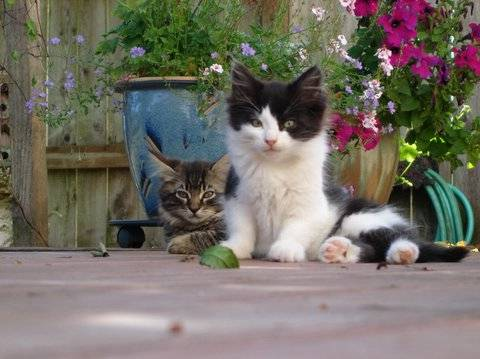

In [ ]:
import IPython

image1 = IPython.display.Image(filename='/content/dogsvscats/train/cat.8414.jpg')
display(image1)

### Prepare dataset

In [ ]:
from torchvision import transforms

input_size = 224
transforms_for_train =  transforms.Compose([
        transforms.RandomResizedCrop(input_size, scale=(0.5, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transforms_for_val_test = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [00.229, 0.224, 0.225])
    ])

#class Dataset
class CustomDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        if img_path.split('/')[-1][-3:] == 'jpg':
            img = Image.open(img_path)
            if self.transform is not None:
                img_transform = self.transform(img)
                label = img_path.split('/')[-1].split('.')[0]
                if label == 'dog':
                  label = 1
                elif label == 'cat':
                  label = 0
        return img_transform, label

dataset_train = CustomDataset(train_list, transform=transforms_for_train)
dataset_valid = CustomDataset(val_list, transform=transforms_for_val_test)
dataset_test = CustomDataset(test_list, transform=transforms_for_val_test)

from torch.utils.data import DataLoader # 데이터 로더 클래스

train_batches = DataLoader(dataset=dataset_train, batch_size=8, shuffle=True)
val_batches = DataLoader(dataset=dataset_valid, batch_size=8, shuffle=False)
test_batches = DataLoader(dataset=dataset_test, batch_size=8, shuffle=False)

### Create model

In [ ]:
!pip install -q timm transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00


In [ ]:
import timm
model = timm.create_model("vit_base_patch32_224_in21k", pretrained=True)

/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_patch32_224_in21k to current vit_base_patch32_224.augreg_in21k.
  model = create_fn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/417M [00:00<?, ?B/s]

In [ ]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
import timm


model = timm.create_model("vit_base_patch32_224_in21k", pretrained=True)
model.head = nn.Sequential(
    nn.Linear(768, 21843, bias=True),
    nn.LeakyReLU(),
    nn.BatchNorm1d(21843),
    nn.Linear(21843, 512, bias=True),
    nn.LeakyReLU(),
    nn.BatchNorm1d(512),
    nn.Linear(512, 1, bias=True),
    nn.Sigmoid()
)
model.to(device)
loss_func = nn.BCELoss()
# optimizer = torch.optim.AdamW(model.parameters(), weight_decay=0.001)
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.0001)
# optimizer = torch.optim.Adamax(model.parameters(), lr=1e-5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

# learning rate scheduler
# https://huggingface.co/docs/transformers/main_classes/optimizer_schedules
from transformers import get_linear_schedule_with_warmup
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps = 0,
  num_training_steps = 10
)

### Define Train Function

In [ ]:
def train_model(model, criterion, optimizer, early_stop, epochs, train_loader, valid_loader):
    train_losses, train_accuracies, valid_losses, valid_accuracies, lowest_loss, lowest_epoch = list(), list(), list(), list(), np.inf, 0

    # DEBUG
    progress_count = 0

    for epoch in range(epochs):
        train_loss, train_accuracy, train_corrects, valid_loss, valid_accuracy, valid_corrects = 0, 0, 0, 0, 0, 0
        train_correct, valid_correct = 0, 0

        start = time.time()
        model.train()
        for train_x, train_y in train_loader:
            train_x = train_x.to(device)
            train_y = train_y.to(device).float() ## BCE Loss는 float type을 받는다.
            train_y = train_y.view(train_y.size(0), -1) ##pred는 (8,1)처럼 2차원이고 train_y는(8)처럼 1차원이므로 둘의 차원을 맞춰줌
            pred = model(train_x)
            loss = criterion(pred, train_y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            y_pred = np.round(pred.detach().cpu()) ## 위 모델 학습 부분의 영향을 받지 않기 위해서 detach로 끊고 간다.+ round를 통해 0.5이상은 1로, 미만은 0으로 나눈다.
            train_correct += y_pred.eq(train_y.detach().cpu()).sum().item()

            # DEBUG
            # if (progress_count % 10) == 0:
            #    print (y_pred.eq(train_y.detach().cpu()).sum().item(), len(y_pred))
            # progress_count += 1


        train_loss = train_loss / len(train_loader) ## mini batch size로 나눠줘서 평균 loss를 구함
        train_losses.append(train_loss)
        train_accuracy = train_correct / len(train_loader.dataset)
        train_accuracies.append(train_accuracy)

        model.eval()
        with torch.no_grad():
            for valid_x, valid_y in valid_loader:
                valid_x = valid_x.to(device)
                valid_y = valid_y.to(device).float()
                valid_y = valid_y.view(valid_y.size(0), -1)
                pred = model(valid_x)
                loss = criterion(pred, valid_y)
                valid_loss += loss.item()

                y_pred = np.round(pred.detach().cpu())
                valid_correct += y_pred.eq(valid_y.detach().cpu()).sum().item()

        valid_loss = valid_loss / len(valid_loader)
        valid_losses.append(valid_loss)
        valid_accuracy = valid_correct / len(valid_loader.dataset)
        valid_accuracies.append(valid_accuracy)

        elapsed_time = time.time() - start
        print(f'[Epoch {epoch+1}/{epochs}]: {elapsed_time:.3f} sec(elapsed time), train loss: {train_losses[-1]:.4f}, train acc: {train_accuracy * 100:.3f}% / valid loss: {valid_losses[-1]:.4f}, valid acc: {valid_accuracy * 100:.3f}%')

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1]
            lowest_epoch = epoch
            best_model = deepcopy(model.state_dict())
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch:
                print ("Early Stopped", epoch, "epochs")
                break

        scheduler.step()

    model.load_state_dict(best_model)
    return model, lowest_loss, train_losses, valid_losses, train_accuracies, valid_accuracies



### Training

In [ ]:
model, lowest_loss, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, loss_func, optimizer, 0, 10, train_batches, val_batches)

[Epoch 1/10]: 384.380 sec(elapsed time), train loss: 0.1053, train acc: 96.396% / valid loss: 0.0250, valid acc: 99.120%
[Epoch 2/10]: 376.444 sec(elapsed time), train loss: 0.0706, train acc: 97.676% / valid loss: 0.0287, valid acc: 98.920%
[Epoch 3/10]: 377.956 sec(elapsed time), train loss: 0.0576, train acc: 98.102% / valid loss: 0.0215, valid acc: 99.200%
[Epoch 4/10]: 377.317 sec(elapsed time), train loss: 0.0453, train acc: 98.524% / valid loss: 0.0257, valid acc: 99.200%
[Epoch 5/10]: 377.161 sec(elapsed time), train loss: 0.0394, train acc: 98.693% / valid loss: 0.0335, valid acc: 99.040%
[Epoch 6/10]: 379.684 sec(elapsed time), train loss: 0.0308, train acc: 99.013% / valid loss: 0.0307, valid acc: 99.160%
[Epoch 7/10]: 376.727 sec(elapsed time), train loss: 0.0317, train acc: 98.947% / valid loss: 0.0279, valid acc: 99.200%
[Epoch 8/10]: 375.111 sec(elapsed time), train loss: 0.0215, train acc: 99.342% / valid loss: 0.0307, valid acc: 99.200%
[Epoch 9/10]: 374.566 sec(elapse

### Save Model

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/00_data/dogs-vs-cats/'
torch.save(model.state_dict(), PATH + 'model_vit_base_patch32_224_in21k_linear_schedule_with_warmup_adam_1e5.pth')  # 모델 객체의 state_dict 저장

### Load Model

In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/00_data/dogs-vs-cats/'
model.load_state_dict(torch.load(PATH + 'model_vit_base_patch32_224_in21k_linear_schedule_with_warmup_adam_1e5.pth'))

<All keys matched successfully>

### Predict & Submit

In [ ]:
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))
dataset_test = CustomDataset(test_list, transform=transforms_for_val_test)
test_batches = DataLoader(dataset=dataset_test, batch_size=8, shuffle=False)

def predict(model, data_loader):
    ids = list()
    with torch.no_grad():
        model.eval()
        ret = None
        for img, fileid in data_loader:
            img = img.to(device)
            pred = model(img)
            ids += list(fileid)
            if ret is None:
                ret = pred.cpu().numpy()
            else:
                ret = np.vstack([ret, pred.cpu().numpy()])
    return ret, ids

pred, ids = predict(model, test_batches)

In [ ]:
print (pred.shape, len(ids))

(12500, 1) 12500


### Submission

In [ ]:
submission = pd.DataFrame({'id': ids, 'label': np.clip(pred, 0.006, 1-0.006).squeeze()})
submission.sort_values(by='id', inplace=True)
submission.reset_index(drop=True, inplace=True)
submission.to_csv('submission.csv', index=False)

### Test for Optimal Cliping

In [ ]:
submission = pd.DataFrame({'id': ids, 'label': np.clip(pred, 0.007, 1-0.007).squeeze()})
submission.sort_values(by='id', inplace=True)
submission.reset_index(drop=True, inplace=True)
submission.to_csv('submission.csv', index=False)